# Task 2.3 - Physics-augmented neural network model

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from copy import deepcopy
from keras import optimizers
from keras import losses

from src.models import TransIsoInvariantsICNN
from src.data_import import load_data, get_pann_dataset, get_train_dataset
from src.plots import plot_loss
from src.predict_utils import predict_identity_F_PANN
from src.plot_and_predict import predict_and_plot_pann_model

2024-12-15 18:53:08.851932: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:53:08.855159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:53:08.866381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 18:53:08.886121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 18:53:08.891986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:53:08.905834: I tensorflow/core/platform/cpu_feature_gu

### Load Datasets

In [2]:
calibration_dir = os.path.abspath('calibration')
test_dir = os.path.abspath('test')

train_names = ['biaxial', 'pure_shear', 'uniaxial']
test_names = ['biax_test', 'mixed_test']
train_paths = {name: os.path.join(calibration_dir, f'{name}.txt') for name in train_names}
test_paths = {name: os.path.join(test_dir, f'{name}.txt') for name in test_names}

train_data = {key: load_data(path) for key, path in train_paths.items()}
test_data = {key: load_data(path) for key, path in test_paths.items()}

## PANN calibration on stress Tensors $P$

/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


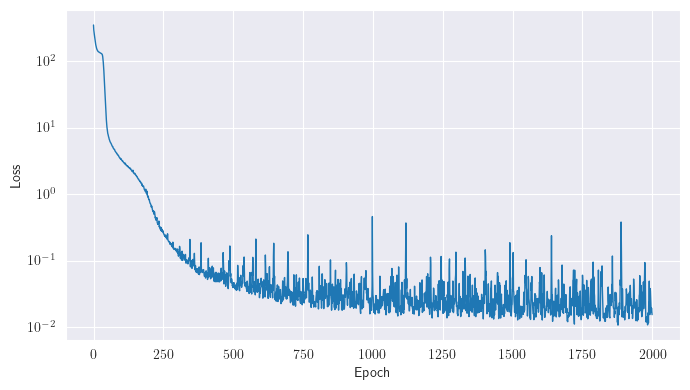

In [3]:
train_stress_features, train_stress_labels = get_train_dataset(train_data, get_pann_dataset, train_names)
pann_stress_model = TransIsoInvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=True
)
pann_stress_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_stress_h = pann_stress_model.fit(
    train_stress_features, train_stress_labels, batch_size=32, epochs=2000, verbose=0
)
pann_stress_loss = pann_stress_h.history['loss']
plot_loss(pann_stress_loss)

### Model Evaluation

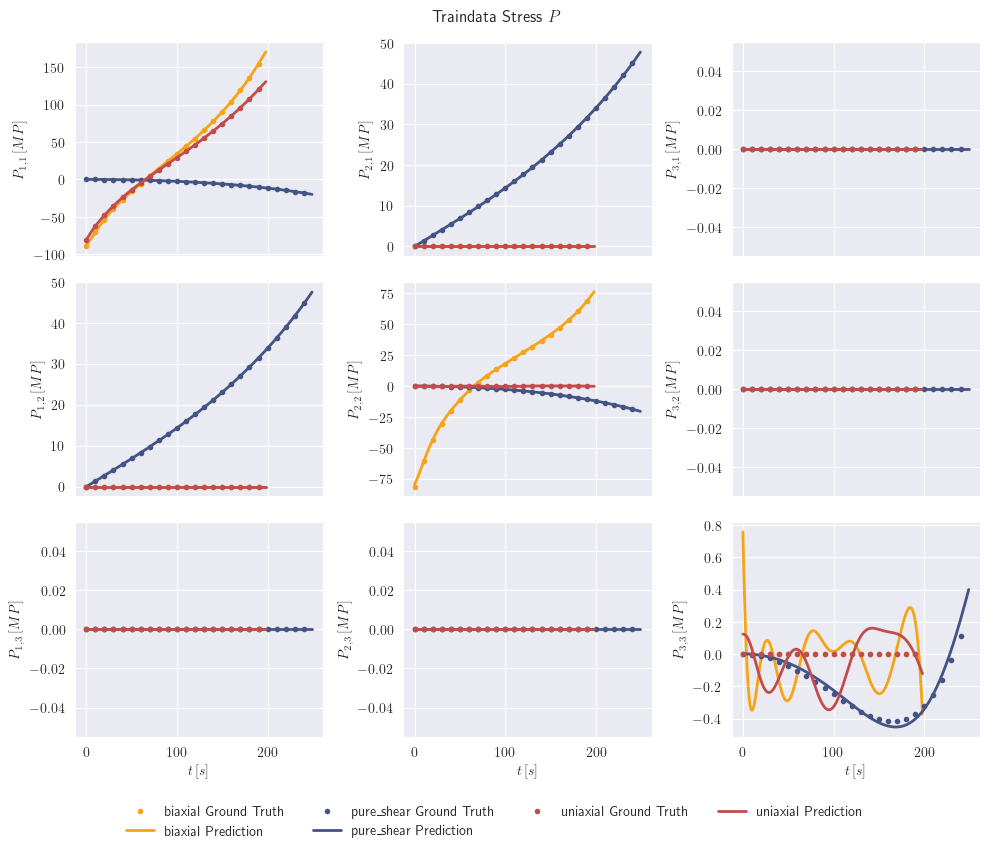

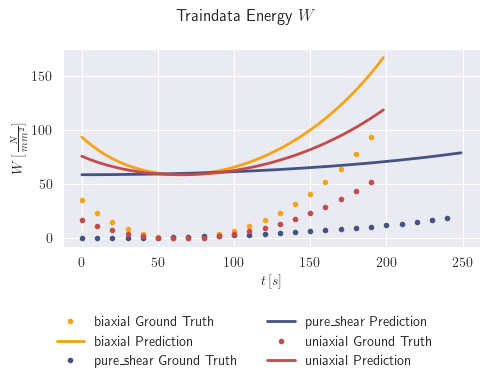

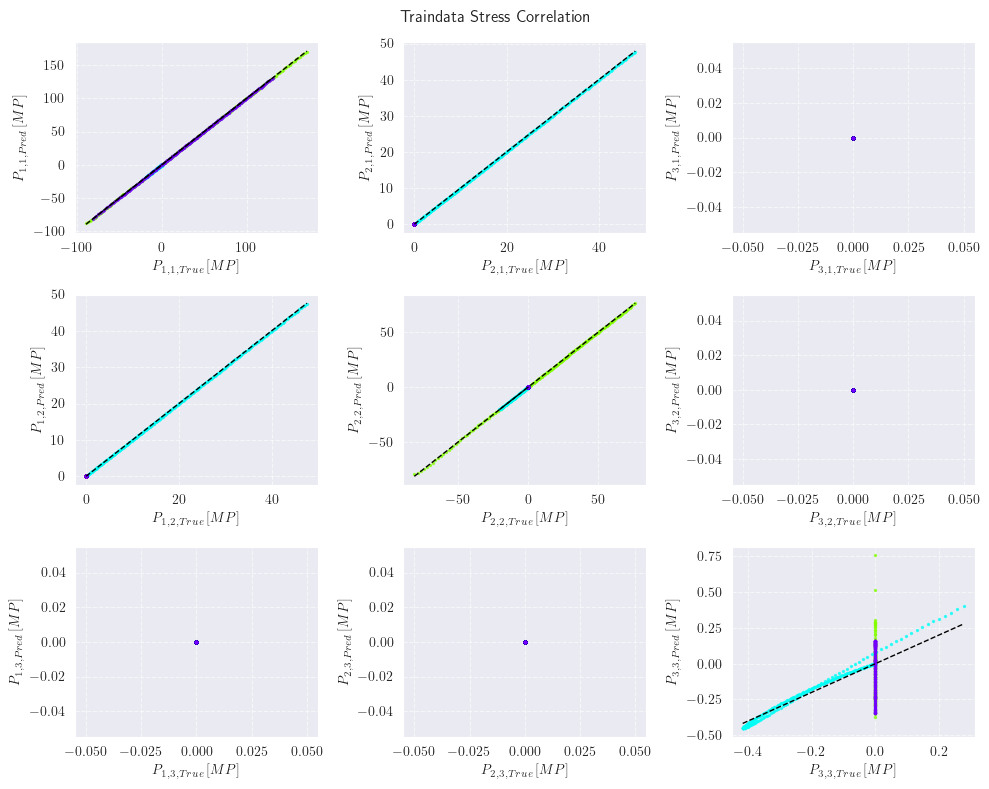

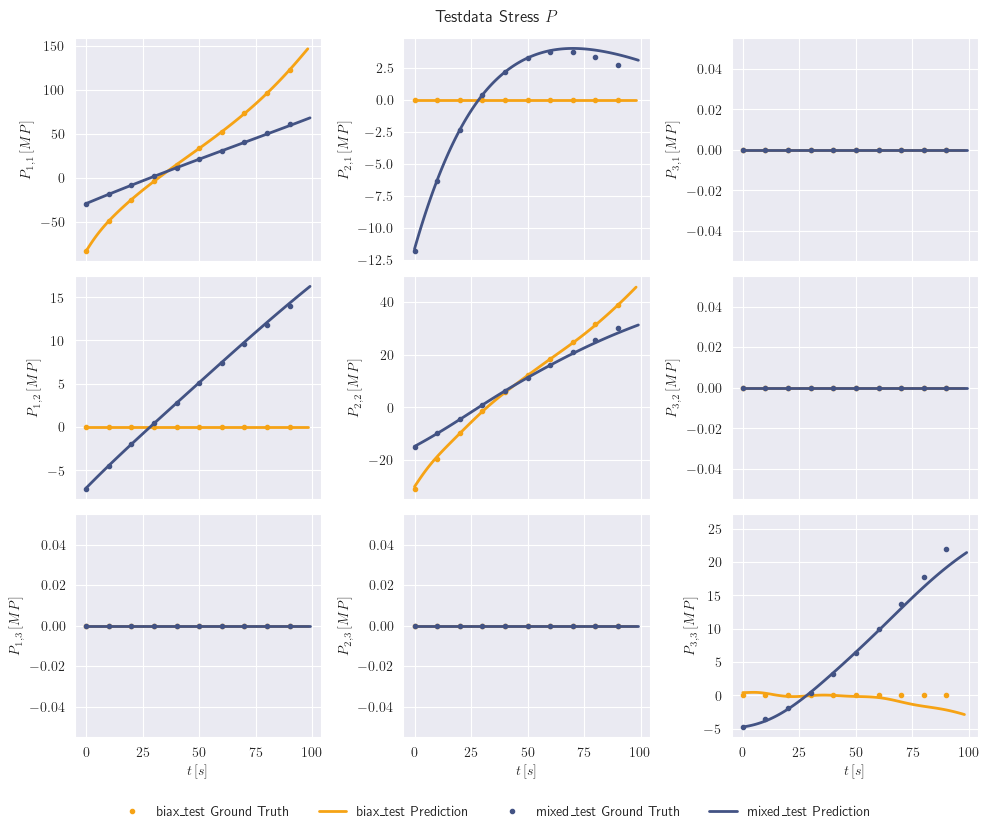

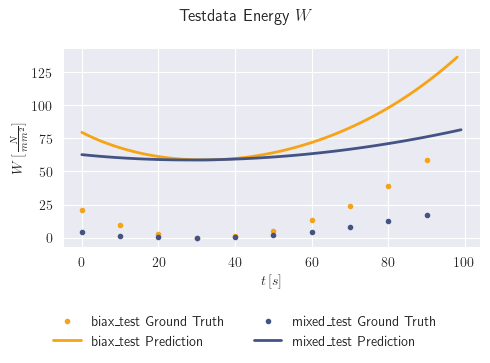

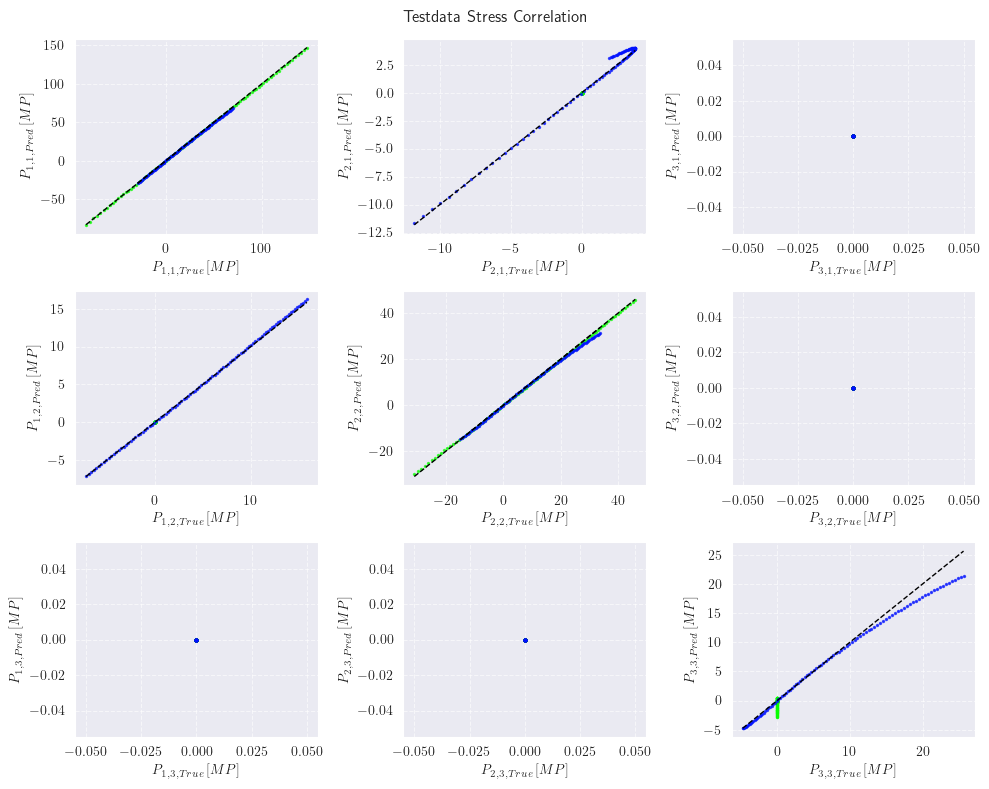

({'biax_test': array([[-8.28734283e+01,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -3.09534683e+01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00, -3.81469727e-06],
         [-7.89034729e+01,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -2.97044678e+01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.51023254e+01,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -2.84784107e+01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00, -7.62939453e-06],
         [-7.14560165e+01,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -2.72747936e+01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.79519577e+01,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -2.60931110e+01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  7.62939453e-06],
         [-6.45789261e+01,  0.00000000e+00,  0.00000000e+00,
      

In [4]:
_ = predict_and_plot_pann_model(pann_stress_model, train_data, suptitle='Traindata')
_ = predict_and_plot_pann_model(pann_stress_model, test_data, suptitle='Testdata')

## Test $F=I$ for stress and energy

### PANN calibration on stress Tensor $P$

In [5]:
predict_identity_F_PANN(pann_stress_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
P predicted: 
[[[0.05905151 0.         0.        ]
  [0.         0.00148773 0.        ]
  [0.         0.         0.00148773]]]
W predicted: 
[[58.638763]]


### PANN calibration on energy $W$

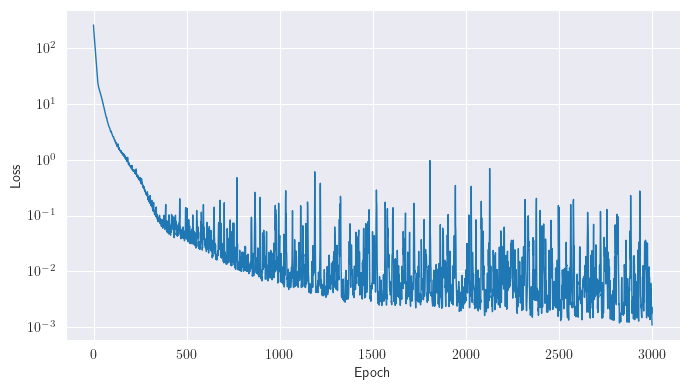

In [6]:
train_energy_features, train_energy_labels = get_train_dataset(train_data, lambda x: get_pann_dataset(x, 'W'), train_names)
pann_energy_model = TransIsoInvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=False
)
pann_energy_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_energy_h = pann_energy_model.fit(
    train_energy_features, train_energy_labels, batch_size=32, epochs=3000, verbose=0
)
pann_energy_loss = pann_energy_h.history['loss']
plot_loss(pann_energy_loss)

In [7]:
predict_identity_F_PANN(pann_energy_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
P predicted: 
[[[-0.45688248  0.          0.        ]
  [ 0.         -0.04335403  0.        ]
  [ 0.          0.         -0.04335403]]]
W predicted: 
[[0.01489162]]


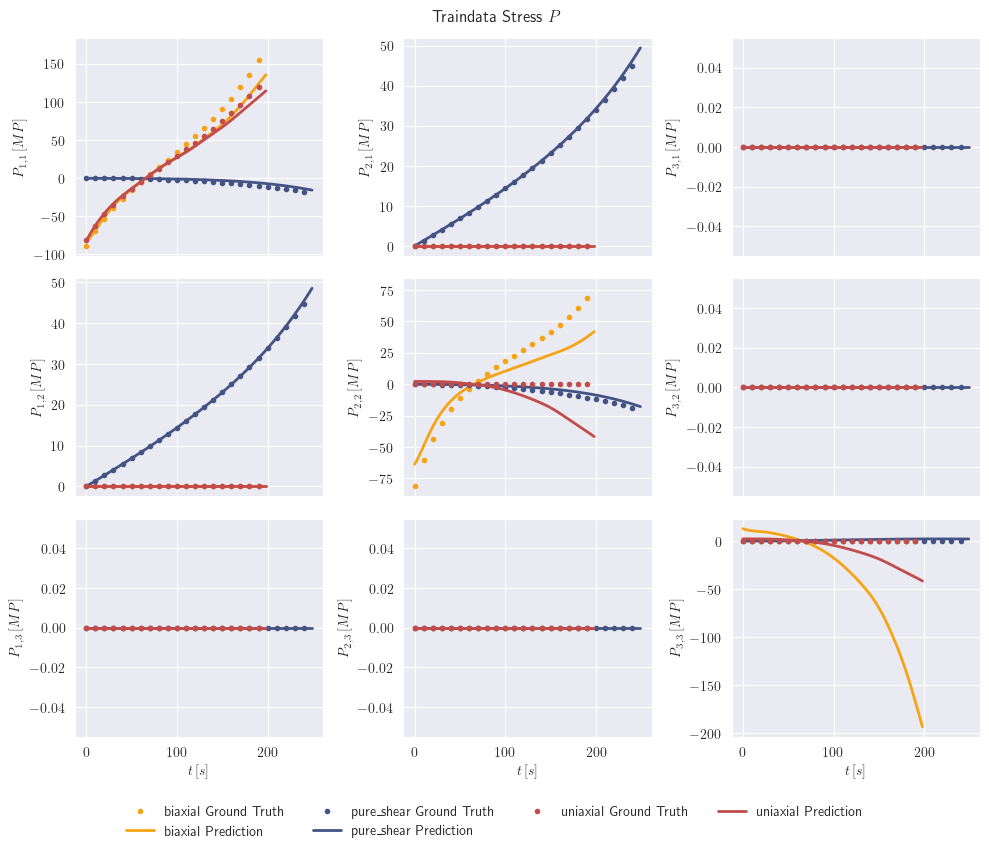

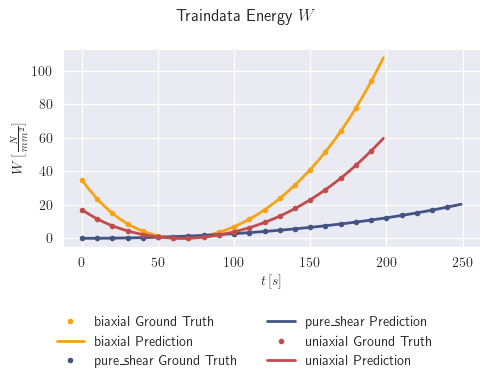

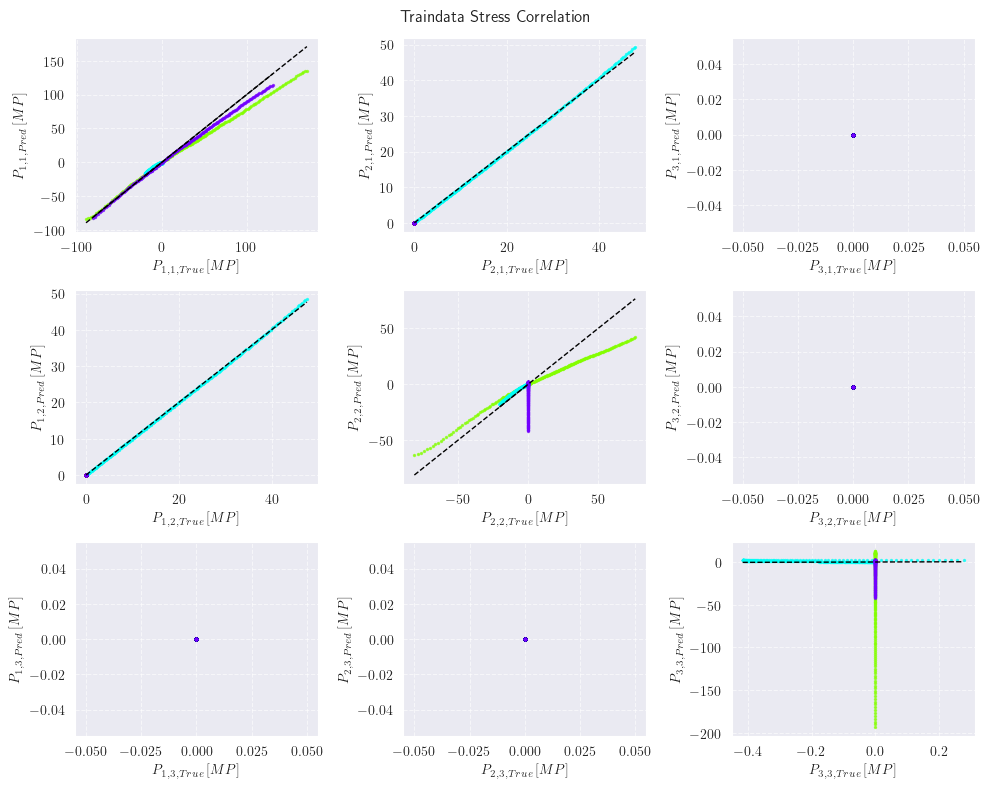

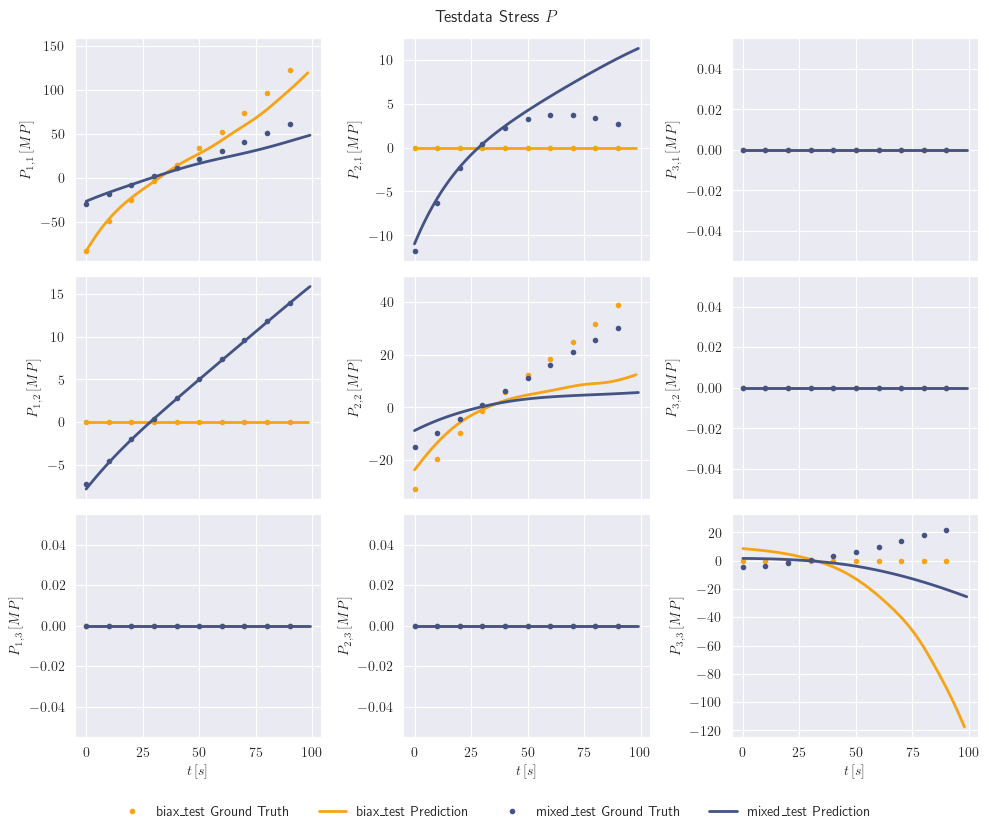

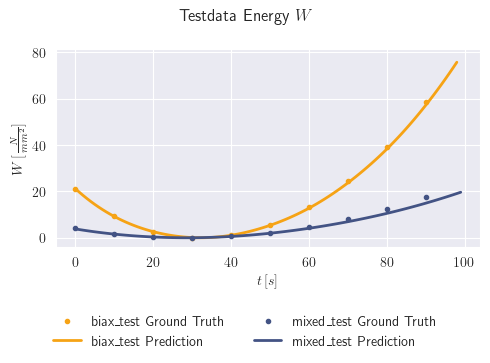

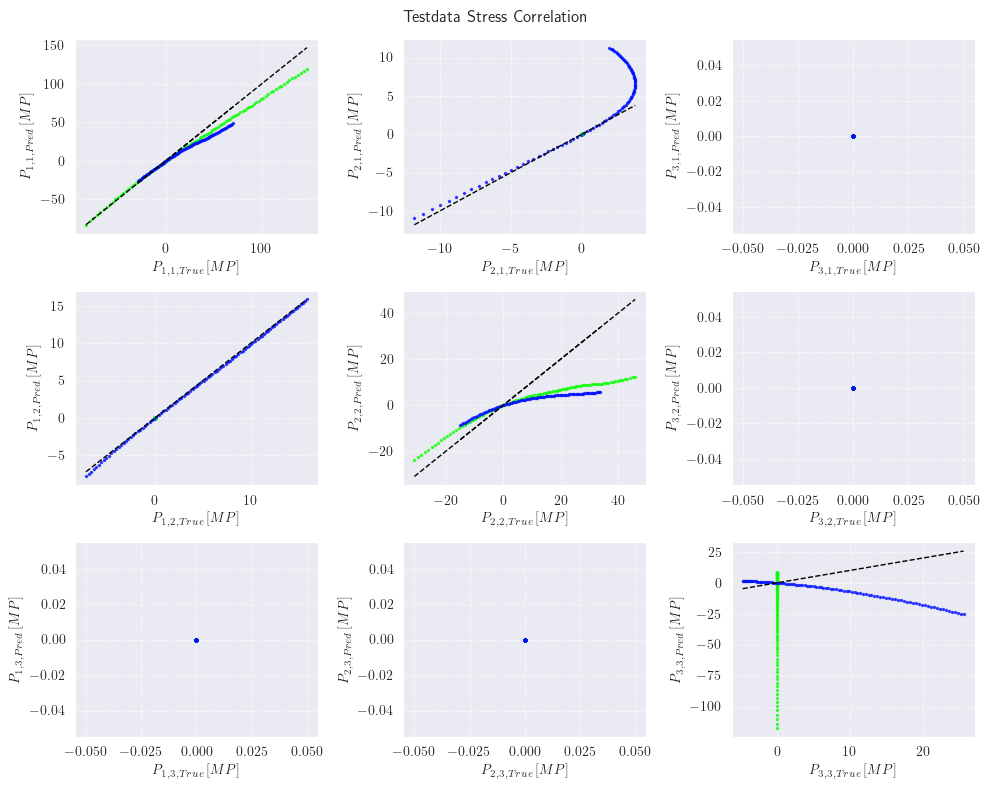

In [8]:
_ = predict_and_plot_pann_model(pann_energy_model, train_data, suptitle='Traindata -')
_ = predict_and_plot_pann_model(pann_energy_model, test_data, suptitle='Testdata -')

### PANN calibration on stress $P$ and energy $W$

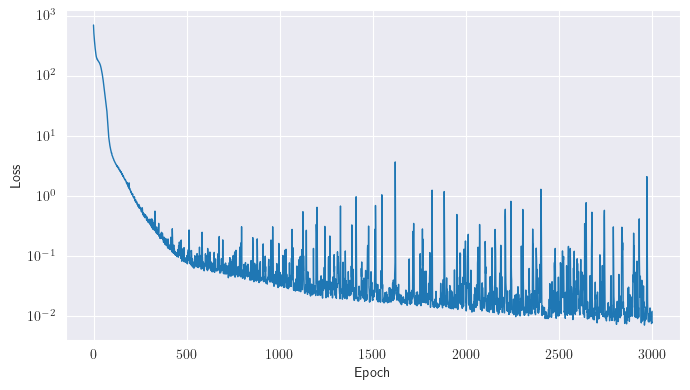

In [3]:
train_both_features, train_both_labels = get_train_dataset(train_data, lambda x: get_pann_dataset(x, 'WP'), train_names)
pann_both_model = TransIsoInvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_output_and_derivative=True
)
pann_both_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_both_h = pann_both_model.fit(
    train_both_features, train_both_labels, batch_size=32, epochs=3000, verbose=0
)
pann_both_loss = pann_both_h.history['loss']
plot_loss(pann_both_loss)

In [4]:
predict_identity_F_PANN(pann_both_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
P predicted: 
[[[-0.0976181   0.          0.        ]
  [ 0.         -0.09505081  0.        ]
  [ 0.          0.         -0.09505081]]]
W predicted: 
[[-0.01413536]]


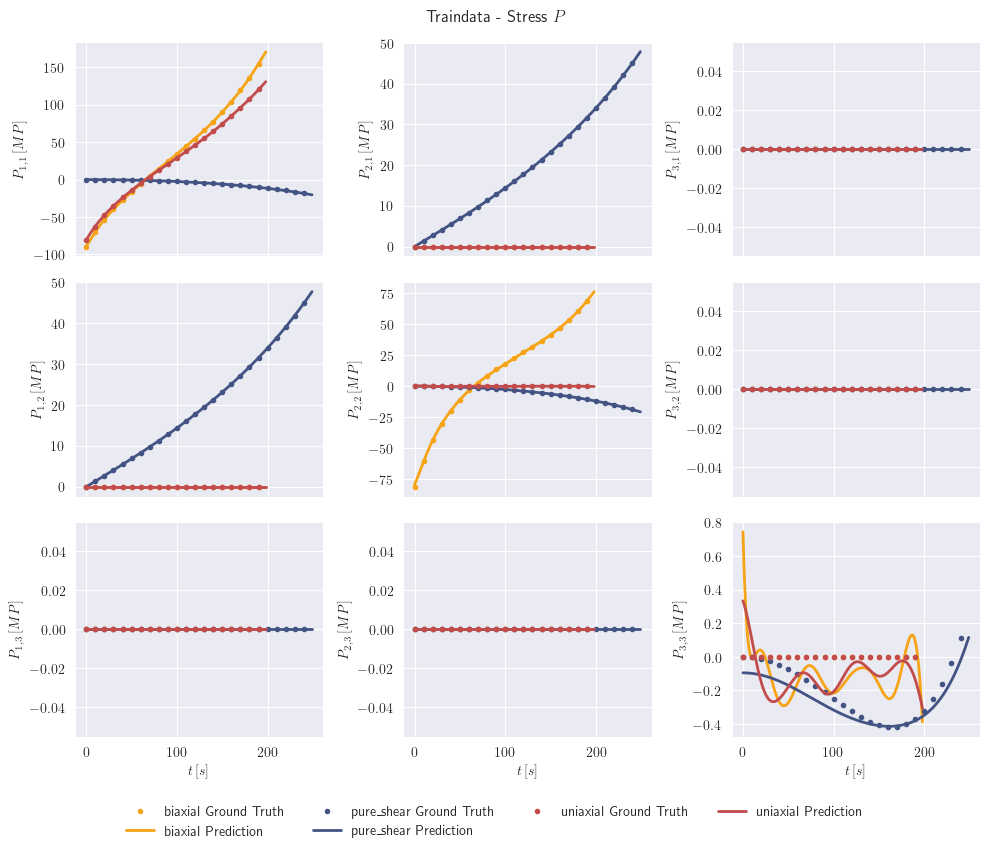

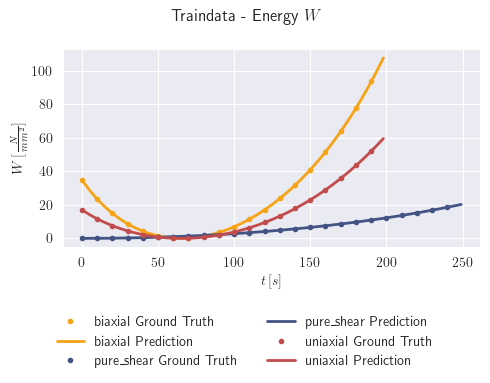

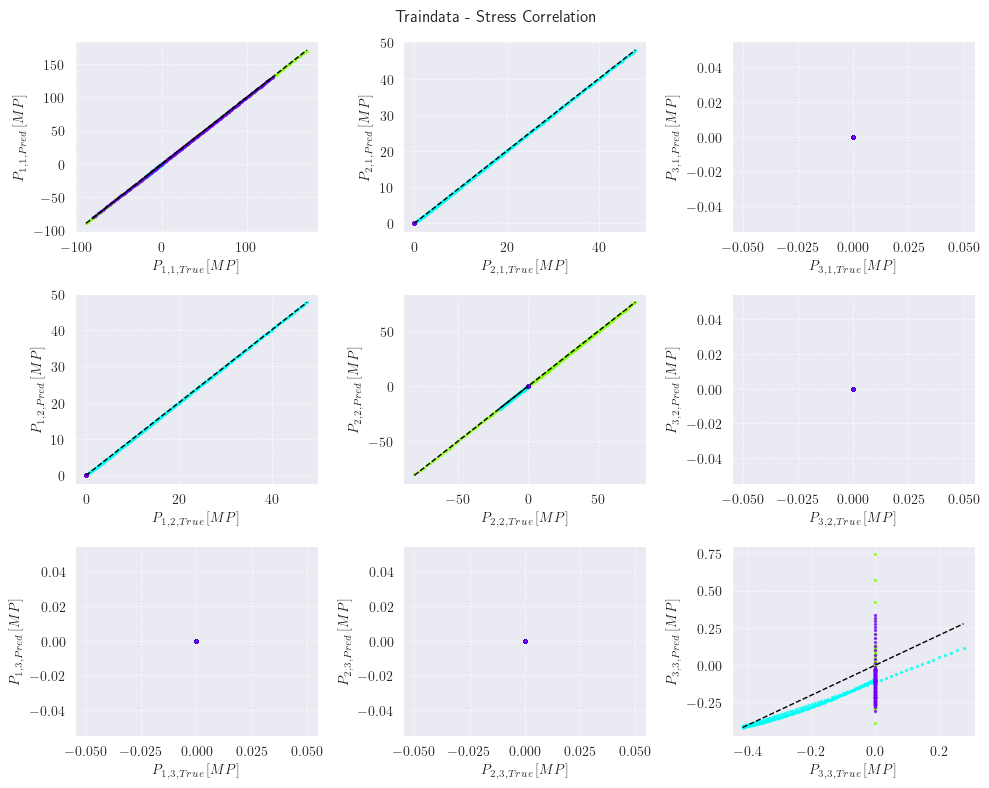

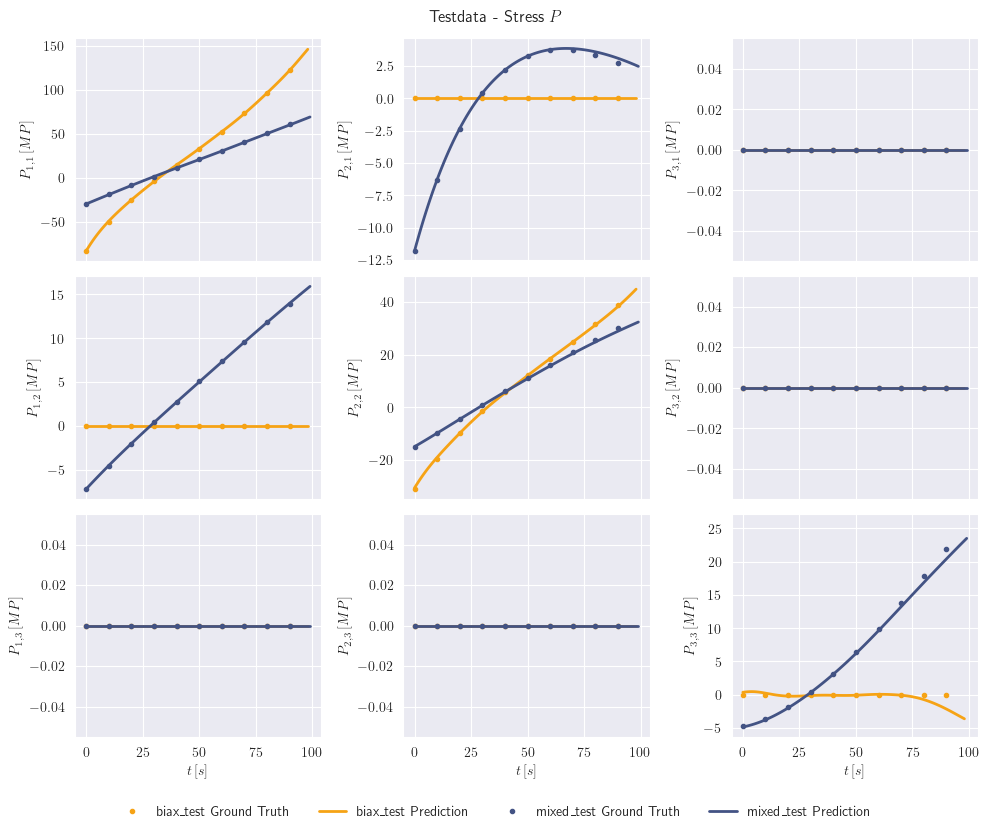

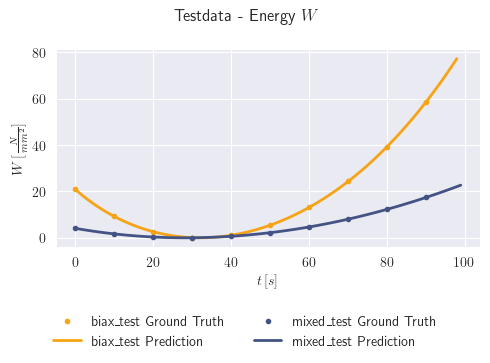

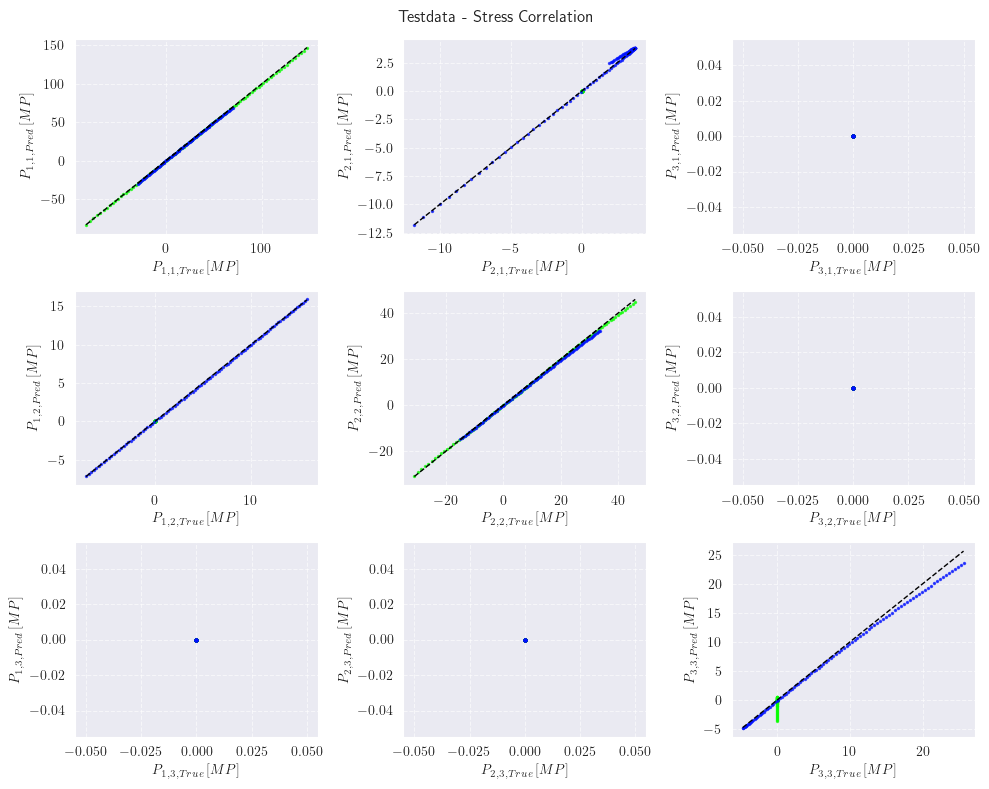

In [7]:
_ = predict_and_plot_pann_model(pann_both_model, train_data, suptitle='Traindata -')
_ = predict_and_plot_pann_model(pann_both_model, test_data, suptitle='Testdata -')

## Model calibration on one load case

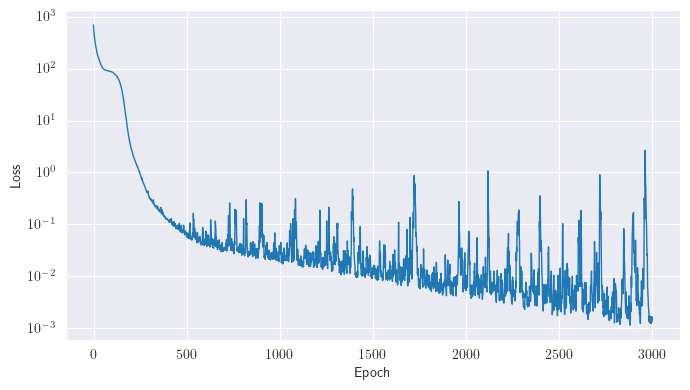

In [7]:
train_one_features, train_one_labels = get_train_dataset(train_data, lambda x: get_pann_dataset(x, 'WP'), ['uniaxial'])
pann_one_model = TransIsoInvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_output_and_derivative=True
)
pann_one_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
one_h = pann_one_model.fit(
    train_one_features, train_one_labels, batch_size=32, epochs=3000, verbose=0)
one_loss = one_h.history['loss']
plot_loss(one_loss)

### Model Evaluation

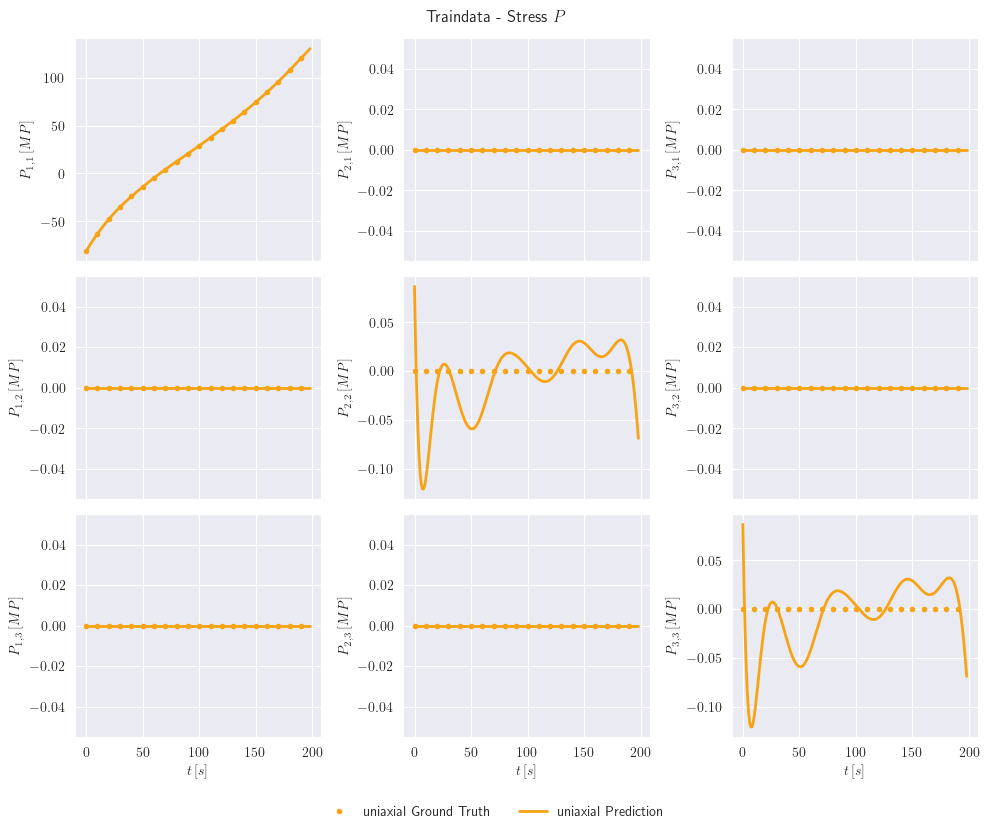

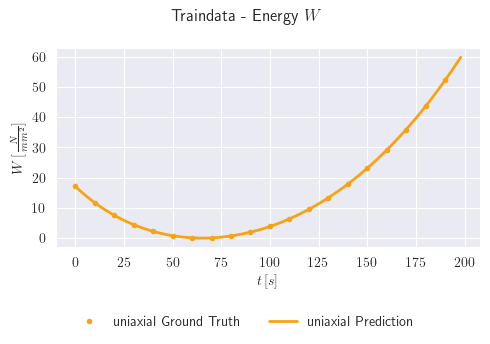

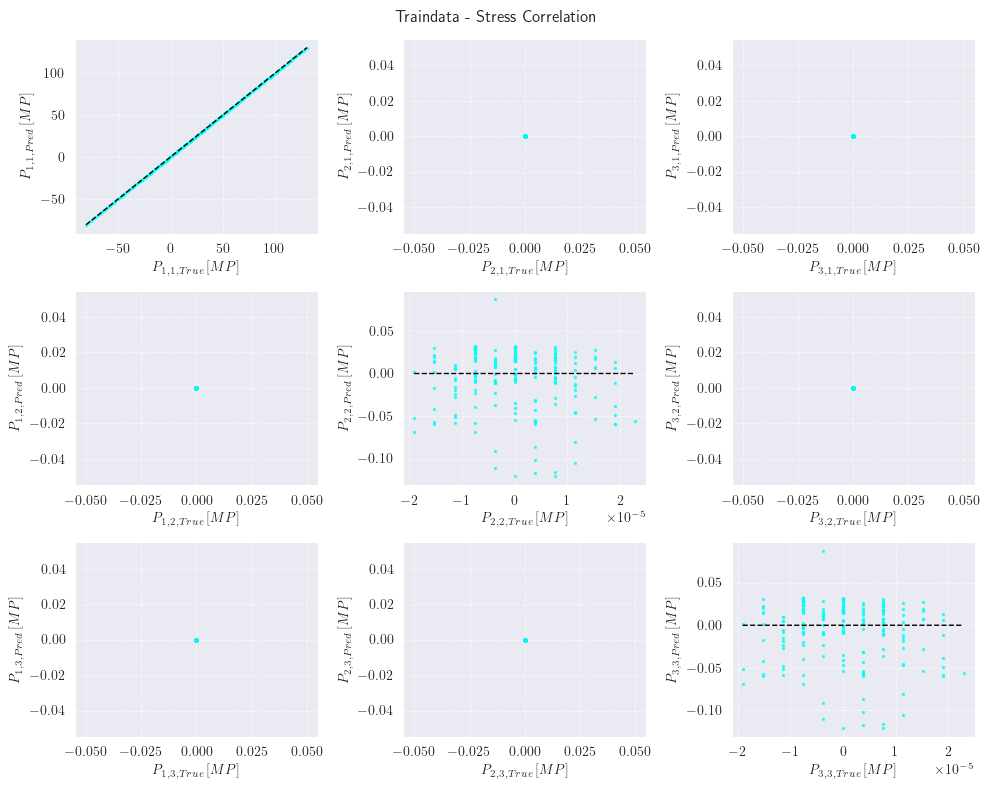

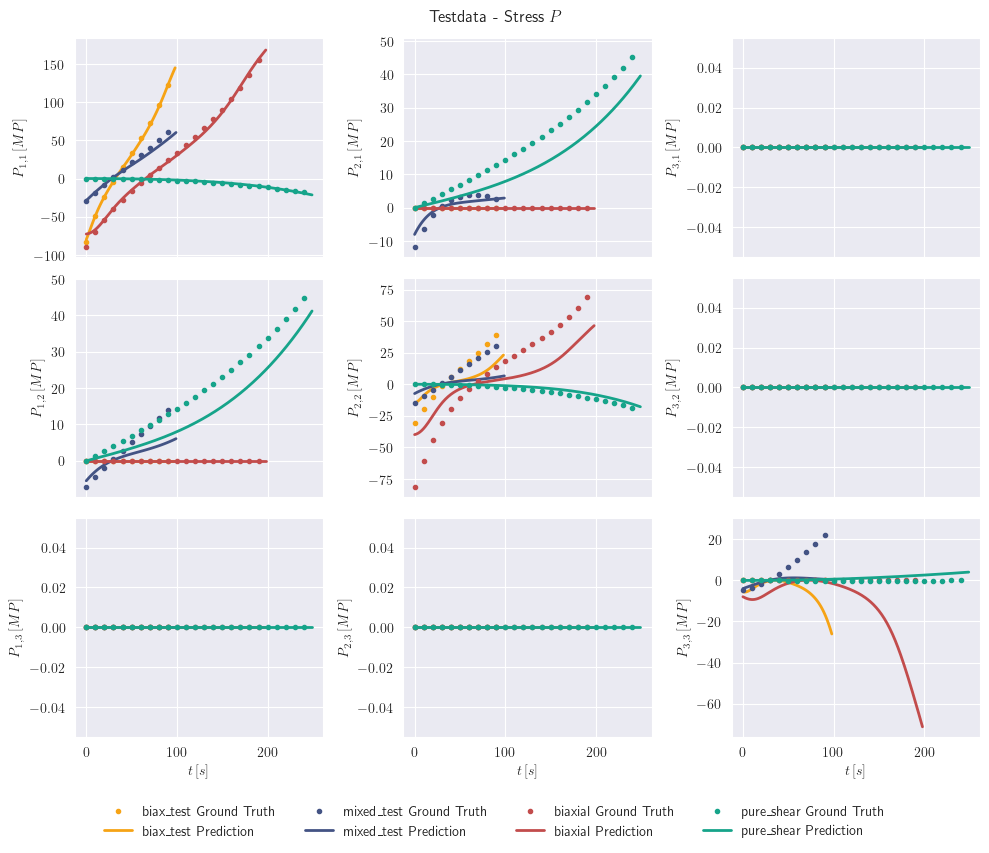

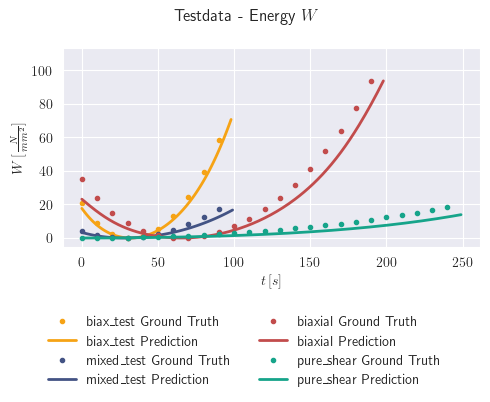

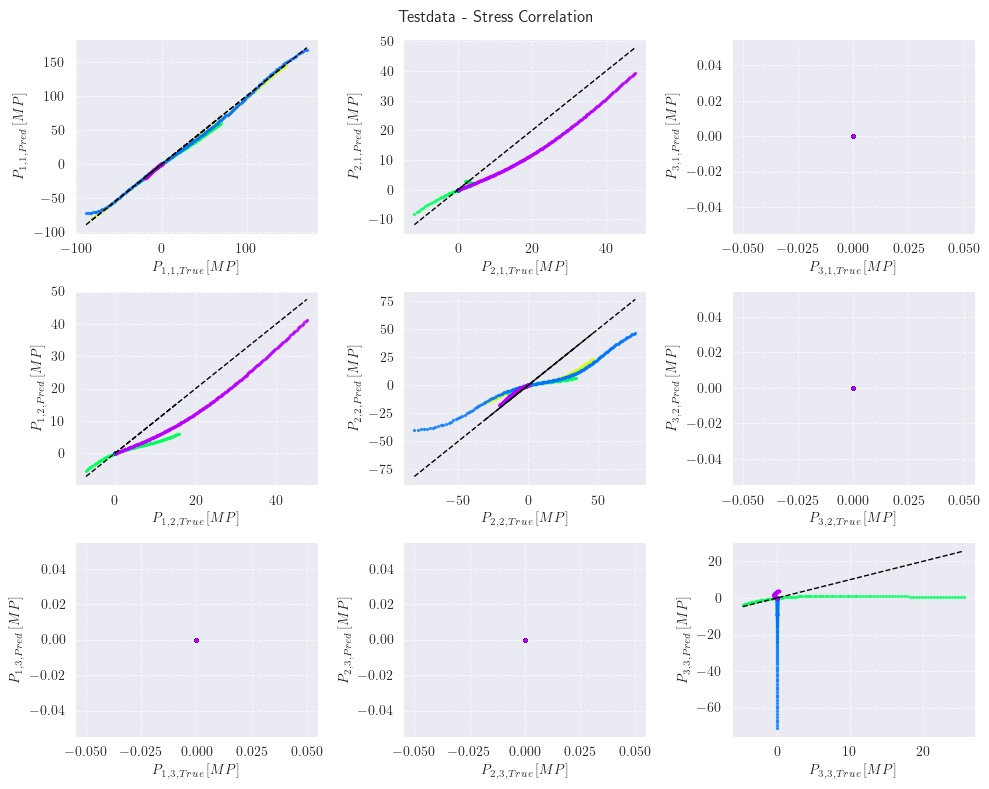

In [8]:
_ = predict_and_plot_pann_model(pann_one_model, {key: train_data[key] for key in ['uniaxial']}, suptitle='Traindata -')
temp_test_data = deepcopy(test_data)

for key in train_names:
    if key != 'uniaxial':
        temp_test_data[key] = train_data[key]
_ = predict_and_plot_pann_model(pann_one_model, temp_test_data, suptitle='Testdata -')